### This is the accompanying code for a tutorial on Medium. Click below to view the tutorial. 
**[Tutorial in English](https://medium.com/tutorial-by-winston-wang/beginners-guide-to-fine-tuning-models-using-mlx-on-apple-silicon-1a21ebb70aed), [简体中文](https://medium.com/tutorial-by-winston-wang/在apple-silicon上使用mlx对模型进行微调的新手教程-f5f9959d8961)**

## Load the model from HuggingFace

In [ ]:
from huggingface_hub import login
access_token = 'hf_************' # paste your token here
login(access_token)

**When loading the model, we can load the tokenizer together, making subsequent operations more convenient:**

In [2]:
from mlx_lm import generate, load

model, tokenizer = load("google/gemma-2-2b-it")

**Edit a prompt to ask the model a question and test the model loading.**

In [3]:
prompt = "What is under-fitting and overfitting in machine learning?"

messages = [{"role": "user", "content": prompt}]

prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

response = generate(model, tokenizer, prompt=prompt, verbose=True, max_tokens = 100)

Prompt: <bos><start_of_turn>user
What is under-fitting and overfitting in machine learning?<end_of_turn>
<start_of_turn>model

Let's break down underfitting and overfitting in machine learning:

**Understanding the Basics**

* **Machine Learning:**  Machine learning is a type of artificial intelligence (AI) where computers learn from data without explicit programming. They use algorithms to identify patterns and make predictions.
* **Model:** A model is a mathematical representation of the relationship between input data and desired output. Think of it as a simplified version of the real-world phenomenon you're trying to understand.

**
Prompt: 22 tokens, 72.806 tokens-per-sec
Generation: 100 tokens, 12.132 tokens-per-sec
Peak memory: 7.535 GB


## Loading the dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("win-wang/Machine_Learning_QA_Collection")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Convert the dataset to DataFrame format and check it.**

In [5]:
import pandas as pd

train_set = pd.DataFrame(ds["train"])
dev_set = pd.DataFrame(ds["validation"])
test_set = pd.DataFrame(ds["test"])

train_set.head()

,text
0,<start_of_turn>user\n I am solving a system...
1,<start_of_turn>user\n I get a gtk-WARNING w...
2,<start_of_turn>user\n I don't really like w...
3,<start_of_turn>user\n I am having trouble f...
4,<start_of_turn>user\n How do Recurrent Neur...


**Convert datasets into lists for MLX**

In [6]:
def preprocess(dataset):
    return dataset["text"].tolist()
    
train_set, dev_set, test_set = map(preprocess, (train_set, dev_set, test_set))

## Model fine-tuning

In [7]:
import matplotlib.pyplot as plt
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, TrainingArgs 
from mlx_lm.tuner import linear_to_lora_layers
from pathlib import Path
import json

**Create a directory to save the adapter configuration and weights.**

In [8]:
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

**Set the LoRA parameters and Save the LoRA configuration to the adapter path.**

In [9]:
lora_config = {
 "lora_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

In [10]:
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

**Set the training parameters.**

In [11]:
training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=200,
    steps_per_eval=50
)

**Freeze the base model, Convert the linear layers to LoRA layers, and Check the trainable model parameters.**

In [12]:
model.freeze()

Model(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2304)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_dims=2304, output_dims=2048, bias=False)
        (k_proj): Linear(input_dims=2304, output_dims=1024, bias=False)
        (v_proj): Linear(input_dims=2304, output_dims=1024, bias=False)
        (o_proj): Linear(input_dims=2048, output_dims=2304, bias=False)
        (rope): RoPE(256, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): Linear(input_dims=2304, output_dims=9216, bias=False)
        (down_proj): Linear(input_dims=9216, output_dims=2304, bias=False)
        (up_proj): Linear(input_dims=2304, output_dims=9216, bias=False)
      )
      (input_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_d

In [13]:
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

In [14]:
num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 491520


**Set the optimizer, Build a class to record the data during the training process**

In [15]:
model.train()

Model(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2304)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_dims=2304, output_dims=2048, bias=False)
        (k_proj): Linear(input_dims=2304, output_dims=1024, bias=False)
        (v_proj): Linear(input_dims=2304, output_dims=1024, bias=False)
        (o_proj): Linear(input_dims=2048, output_dims=2304, bias=False)
        (rope): RoPE(256, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): Linear(input_dims=2304, output_dims=9216, bias=False)
        (down_proj): Linear(input_dims=9216, output_dims=2304, bias=False)
        (up_proj): Linear(input_dims=2304, output_dims=9216, bias=False)
      )
      (input_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_d

In [16]:
opt = optim.Adam(learning_rate=1e-5)

In [17]:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))
        
metrics = Metrics()

**Start Fine-tuning**

In [18]:
train(
    model = model,
    tokenizer = tokenizer,
    args = training_args,
    optimizer = opt,
    train_dataset = train_set,
    val_dataset = dev_set,
    training_callback = metrics
)

Starting training..., iters: 200
Iter 1: Val loss 3.161, Val took 49.532s
Iter 10: Train loss 3.801, Learning Rate 1.000e-05, It/sec 0.513, Tokens/sec 377.133, Trained Tokens 7348, Peak mem 25.797 GB
Iter 20: Train loss 3.050, Learning Rate 1.000e-05, It/sec 0.315, Tokens/sec 228.261, Trained Tokens 14605, Peak mem 29.260 GB
Iter 30: Train loss 2.622, Learning Rate 1.000e-05, It/sec 0.085, Tokens/sec 103.549, Trained Tokens 26780, Peak mem 37.153 GB
Iter 40: Train loss 2.764, Learning Rate 1.000e-05, It/sec 0.326, Tokens/sec 307.783, Trained Tokens 36228, Peak mem 37.153 GB
Iter 50: Val loss 2.721, Val took 36.993s
Iter 50: Train loss 2.637, Learning Rate 1.000e-05, It/sec 4.204, Tokens/sec 3228.857, Trained Tokens 43909, Peak mem 37.153 GB
Iter 60: Train loss 2.554, Learning Rate 1.000e-05, It/sec 0.208, Tokens/sec 188.639, Trained Tokens 52962, Peak mem 37.153 GB
Iter 70: Train loss 2.499, Learning Rate 1.000e-05, It/sec 0.527, Tokens/sec 377.368, Trained Tokens 60119, Peak mem 37.15

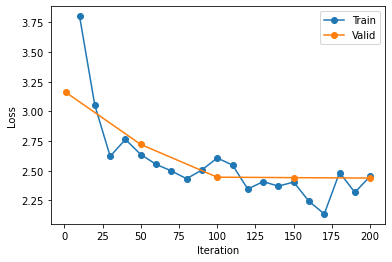

In [19]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

## Use the parameters from the original model and adapter file to build the LoRA model.

In [20]:
model_lora, _ = load("google/gemma-2-2b-it", adapter_path="adapters")

In [21]:
generate(model_lora, tokenizer, prompt=prompt, verbose=True)

Prompt: <bos><start_of_turn>user
What is under-fitting and overfitting in machine learning?<end_of_turn>
<start_of_turn>model

Underfitting and overfitting are two common problems in machine learning that can affect the performance of a model.<end_of_turn>
Prompt: 22 tokens, 9.266 tokens-per-sec
Generation: 23 tokens, 11.483 tokens-per-sec
Peak memory: 46.745 GB


'Underfitting and overfitting are two common problems in machine learning that can affect the performance of a model.<end_of_turn>'

## Fusion

In [22]:
!mlx_lm.fuse --model "google/gemma-2-2b-it"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading pretrained model
